In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import ast

## Скачивание

In [2]:
file_id = '1Fo4swaHNL7XW4xQ72It7Hf7L2UmtmbCg'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'dataset.zip'

In [3]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл dataset.zip уже существует.


In [4]:
df = pd.read_csv(output_file, compression='zip')

## Приведение типов

In [5]:
df.head(3)

,Game_ID,Rated,Variant,Speed,Created_At,Last_Move_At,Game_Status,Source,Winner,Opening_Name,...,Black_Inaccuracy,Black_Mistake,Black_Blunder,Black_ACPL,Clocks,Analysis,Total_Time_Init,Total_Time_Increment,Total_Time,Moves
0,PsevV6VH,True,standard,classical,2024-12-15T11:09:25.224000+00:00,2024-12-15T11:55:14.775000+00:00,resign,pool,white,English Opening: Symmetrical Variation,...,5,1,1,47,"[180003, 180003, 178499, 178019, 178339, 17757...","[{'eval': 14}, {'eval': 25}, {'eval': 26}, {'e...",1800,0,1800,Nf3 c5 c4 Nc6 Nc3 g6 e3 Bg7 d4 cxd4 exd4 d6 h3...
1,diLZa8sj,True,standard,classical,2024-10-28T13:54:16.605000+00:00,2024-10-28T14:32:21.403000+00:00,resign,pool,white,"French Defense: Winawer Variation, Advance Var...",...,4,0,1,31,"[180003, 180003, 179827, 179683, 178619, 17936...","[{'eval': 18}, {'eval': 28}, {'eval': 28}, {'e...",1800,0,1800,e4 e6 d4 d5 Nc3 Bb4 e5 Ne7 a3 Bxc3+ bxc3 b6 Bb...
2,O8TSZ7bq,True,standard,classical,2024-10-05T13:58:55.992000+00:00,2024-10-05T14:27:57.120000+00:00,resign,pool,black,London System,...,3,1,5,56,"[180003, 180003, 179707, 179035, 179051, 17678...","[{'eval': 17}, {'eval': 17}, {'eval': 11}, {'e...",1800,0,1800,d4 Nf6 Nf3 g6 Bf4 Bg7 e3 d6 Be2 O-O O-O Nbd7 h...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140792 entries, 0 to 140791
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Game_ID               140792 non-null  object 
 1   Rated                 140792 non-null  bool   
 2   Variant               140792 non-null  object 
 3   Speed                 140792 non-null  object 
 4   Created_At            140792 non-null  object 
 5   Last_Move_At          140792 non-null  object 
 6   Game_Status           140792 non-null  object 
 7   Source                140792 non-null  object 
 8   Winner                127103 non-null  object 
 9   Opening_Name          139522 non-null  object 
 10  Opening_ECO           139522 non-null  object 
 11  Opening_PLY           139522 non-null  float64
 12  White_Player          140565 non-null  object 
 13  White_Title           46713 non-null   object 
 14  White_Rating          140565 non-null  float64
 15  

In [7]:
df['Created_At'] = (
    pd.to_datetime(df['Created_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [8]:
df['Last_Move_At'] = (
    pd.to_datetime(df['Last_Move_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [9]:
df['Clocks'] = df['Clocks'].apply(ast.literal_eval)

## Исследование данных

Посмотрим на пропуски в данных

In [10]:
df.isna().sum()[df.isna().sum() > 0]

Winner          13689
Opening_Name     1270
Opening_ECO      1270
Opening_PLY      1270
White_Player      227
White_Title     94079
White_Rating      227
Black_Player      311
Black_Title     94280
Black_Rating      311
dtype: int64

#### Параметр `Game_ID`

Game_ID - идентификатор партии - категориальный

Проверим на наличие в датасете дубликатов

In [11]:
df['Game_ID'].duplicated().sum()

np.int64(6644)

Удалим дубликаты

In [12]:
df.drop_duplicates(subset=['Game_ID'], inplace=True)

#### Параметр `Rated`

Rated - булевый признак, показывающий, является ли партия рейтинговой (True) или нет (False) - категориальный 

Посмотрим на распределение

In [13]:
df['Rated'].value_counts(dropna=False)

Rated
True     128152
False      5996
Name: count, dtype: int64

Отфильтруем нерейтинговые игры, чтобы избежать ошибок, связанных с некорректной игрой участников в партиях, не идущих на результат.

In [14]:
df = df[df['Rated'] == True].reset_index(drop=True)

#### Параметр `Variant`

Variant - вариант шахмат (например, классические, шахматы 960 и т. д.) - категориальный

In [15]:
df['Variant'].value_counts(dropna=False)

Variant
standard        127831
fromPosition       321
Name: count, dtype: int64

Отфильтруем значения fromPosition, чтобы не искажать данные играми, не начинающими с самого начала.

In [16]:
df = df[df['Variant'] != 'fromPosition'].reset_index(drop=True)

#### Параметр `Speed`

Speed - контроль времени партии (например, блиц, рапид, классика) - категориальный

In [17]:
df['Speed'].value_counts(dropna=False)

Speed
blitz          34301
rapid          29062
bullet         28777
classical      27526
ultraBullet     8165
Name: count, dtype: int64

#### Параметр `Source`

Source - источник партии (турнир, с другом, pool и т.д.) - категориальный

In [18]:
df['Source'].value_counts(dropna=False)

Source
pool      78518
lobby     23716
arena     16850
friend     6645
swiss      2071
api          31
Name: count, dtype: int64

Удалим игры через api, которые из-за нестандартного интерфейса для игрока могли повлиять на его уровень игры

In [19]:
df = df[df['Source'] != 'api'].reset_index(drop=True)

#### Параметр `Winner`

Winner - победитель партии (White, Black или None в случае ничьей) - категориальный

In [20]:
df['Winner'].value_counts(dropna=False, normalize=True)

Winner
white    0.473615
black    0.431049
NaN      0.095336
Name: proportion, dtype: float64

Заполним NA значения параметром draw

In [21]:
df['Winner'] = df['Winner'].fillna(value='draw')

Можно заметить, что в онлайн-шахматах доля побед значительно превышает долю ничьих, что не соответствует практическому опыту офлайн-шахмат.

#### Параметр `Game_Status`

Game_Status - статус завершения партии (ничья, мат, чит и т.д.) - категориальный

In [22]:
df['Game_Status'].value_counts(dropna=False)

Game_Status
resign       70637
outoftime    23142
mate         22103
draw         10392
timeout        775
stalemate      740
cheat           11
Name: count, dtype: int64

Удалим читерные партии из набора (cheat) и партии, где игроку засчитался проигрыш при отключении (timeout)

In [23]:
df = df[~df['Game_Status'].isin(['cheat', 'timeout'])].reset_index(drop=True)

#### Параметр `Opening_Name`

Opening_Name - название дебюта, который был сыгран - категориальный

In [24]:
df['Opening_Name'].value_counts(dropna=False)

Opening_Name
Indian Defense                                                          1736
Sicilian Defense: Closed                                                1448
King's Indian Attack                                                    1187
Zukertort Opening                                                       1168
Modern Defense                                                          1076
                                                                        ... 
Italian Game: Giuoco Piano, Krause Variation                               1
Queen's Gambit Declined: Baltic Defense, Queen Attack Deferred             1
Queen's Indian Defense: Averbakh Variation                                 1
Italian Game: Two Knights Defense, Polerio Defense, Göring Variation       1
Benko Gambit: Fianchetto Variation                                         1
Name: count, Length: 2301, dtype: int64

In [25]:
# TODO:что дальше?

#### Параметр `Opening_ECO`

Opening_ECO - код дебюта по системе ECO (Encyclopaedia of Chess Openings) - категориальный

In [26]:
df['Opening_ECO'].value_counts(dropna=False)

Opening_ECO
A00    6051
A04    3913
A45    3396
A40    3007
A05    2924
       ... 
E31       1
D49       1
A76       1
D98       1
D67       1
Name: count, Length: 488, dtype: int64

In [27]:
# TODO: что дальше?

#### Параметр `Opening_PLY`

Opening_PLY - количество полуходов до выхода из дебютной стадии - числовой

In [28]:
# TODO: логика?

#### Параметр `Created_At`

Created_At - время создания партии - категориальный

In [29]:
# Создаем дополнительное поле - год игры
df['Created_Year'] = df['Created_At'].dt.to_period('Y')

year_counts = df.groupby('Created_Year').size()
year_counts

Created_Year
2014        1
2015       16
2016        7
2017      350
2018      524
2019      481
2020     1810
2021     3343
2022     4854
2023    14388
2024    73290
2025    27950
Freq: Y-DEC, dtype: int64

Удалим данные с 2014 по 2019 годы из-за малого числа наблюдений.

In [30]:
df = df[~df['Created_Year'].astype(
    str).isin(['2014', '2015', '2016', '2017', '2018', '2019'])].reset_index(drop=True)

Теперь посмотрим на распределение

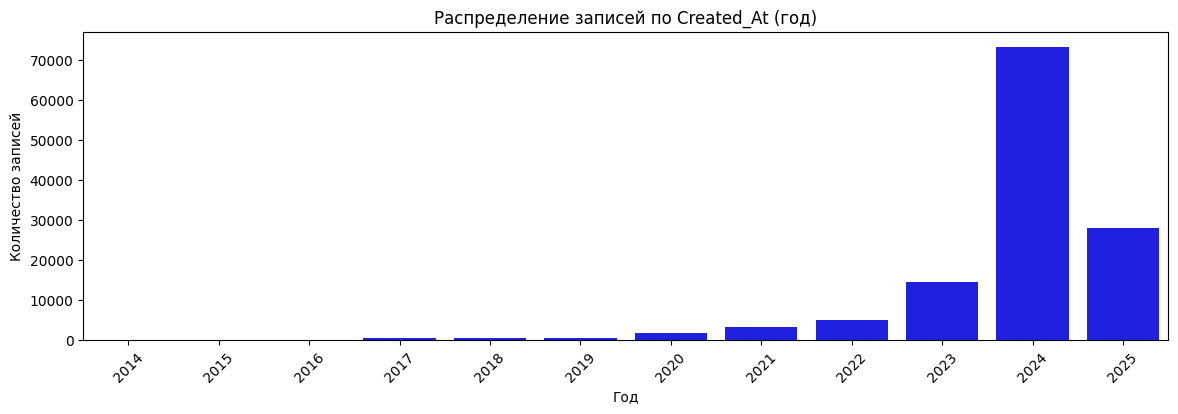

In [31]:
plt.figure(figsize=(14, 4))
sns.barplot(x=year_counts.index.astype(str),
            y=year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (год)")
plt.show()

Посмотрим на распределение игр по месяцам

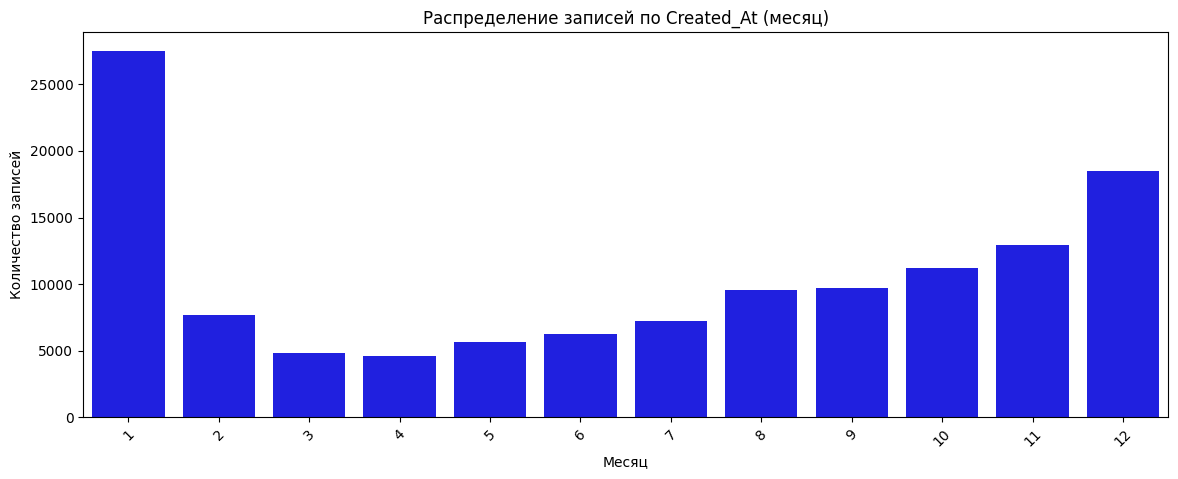

In [32]:
df['Created_Month'] = df['Created_At'].dt.month

month_counts = df.groupby('Created_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=month_counts.index.astype(str),
            y=month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (месяц)")
plt.show()

Чаще всего играют в январе и декабре. Можно выделить спад в весенне-летний период

Узнаем в какой день недели чаще всего играют в шахматы

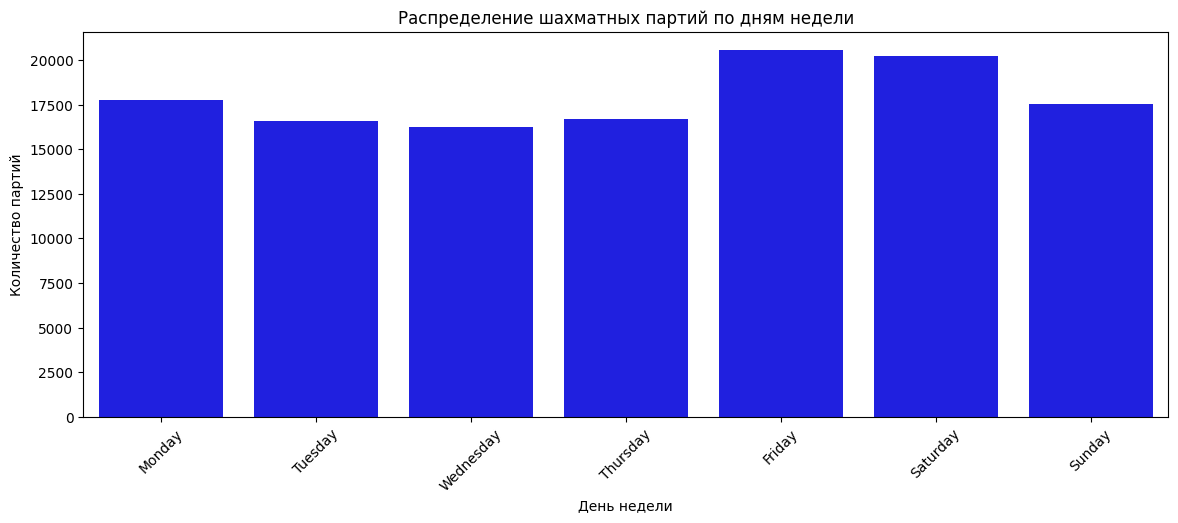

In [33]:
df["weekday"] = df["Created_At"].dt.day_name()
ordered_days = ["Monday", "Tuesday", "Wednesday",
                "Thursday", "Friday", "Saturday", "Sunday"]

day_counts = df["weekday"].value_counts().reindex(ordered_days)


plt.figure(figsize=(14, 5))
sns.barplot(x=day_counts.index, y=day_counts.values,  color='blue')
plt.title("Распределение шахматных партий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество партий")
plt.xticks(rotation=45)
plt.show()

По пятницам и субботам в шахматы играют чаще всего

Узнаем в какой время суток чаще всего играют в шахматы

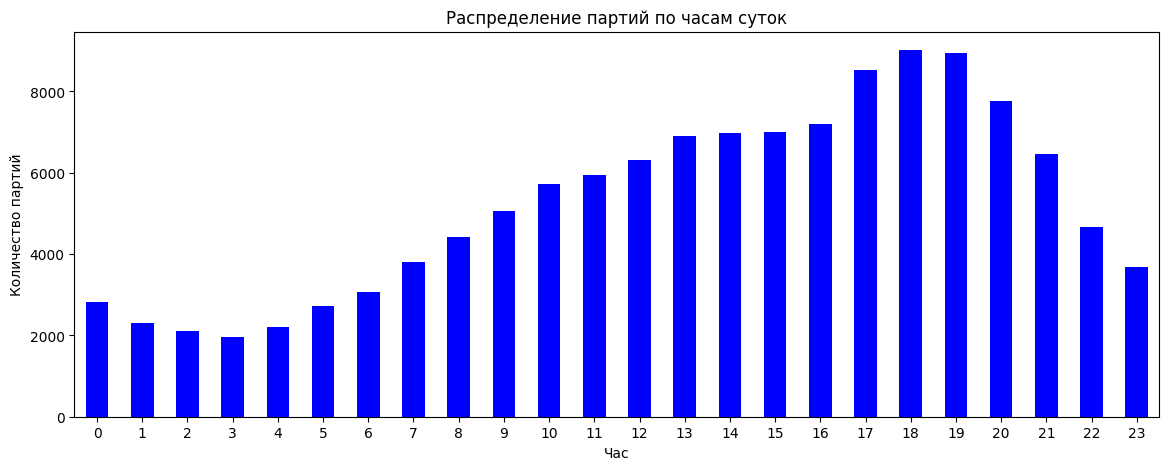

In [34]:
df["Hour"] = df["Created_At"].dt.hour
df["Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Чаще всего люди играют в вечернее время (с 17 до 20 UTC)

#### Параметр `Last_Move_At`

Last_Move_At - время последнего хода в партии - категориальный

In [35]:
# Создаем дополнительное поле - год игры
df['Last_Move_Year'] = df['Last_Move_At'].dt.to_period('Y')

last_move_year_counts = df.groupby('Last_Move_Year').size()
last_move_year_counts

Last_Move_Year
2020     1810
2021     3343
2022     4854
2023    14386
2024    73291
2025    27951
Freq: Y-DEC, dtype: int64

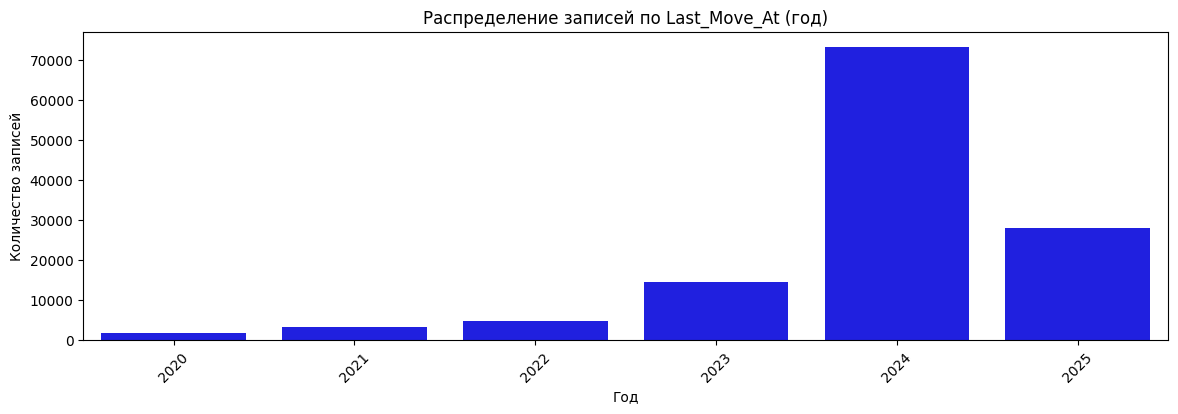

In [36]:
plt.figure(figsize=(14, 4))
sns.barplot(x=last_move_year_counts.index.astype(str),
            y=last_move_year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (год)")
plt.show()

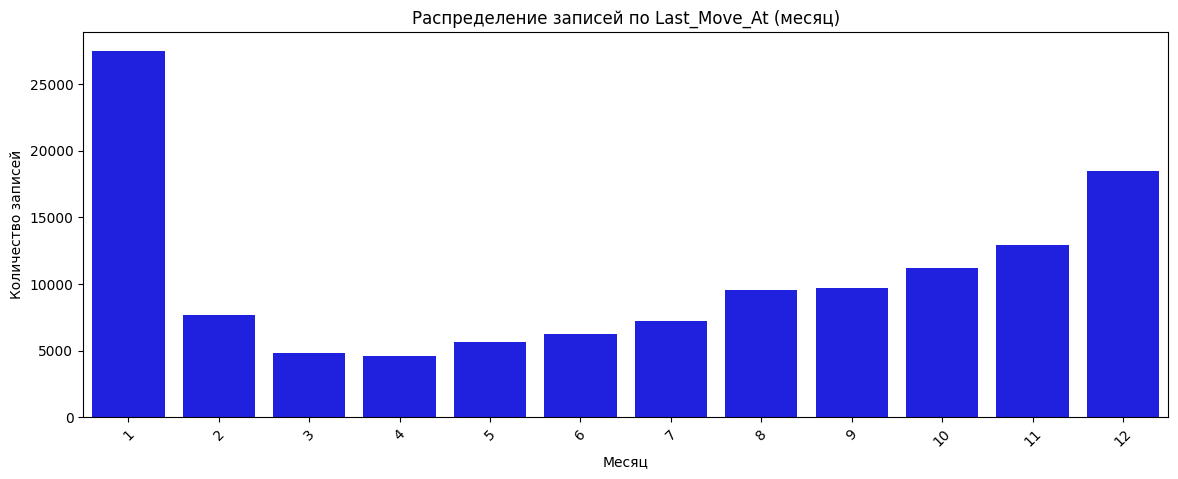

In [37]:
df['Last_Move_Month'] = df['Last_Move_At'].dt.month

last_move_month_counts = df.groupby('Last_Move_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=last_move_month_counts.index.astype(str),
            y=last_move_month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (месяц)")
plt.show()

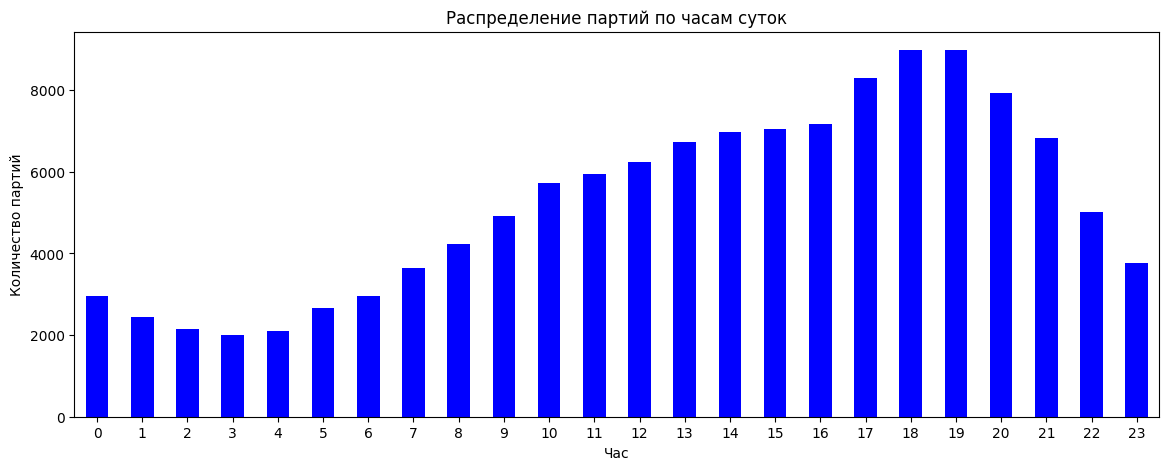

In [38]:
df["Last_Move_Hour"] = df["Last_Move_At"].dt.hour
df["Last_Move_Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Данный параметр имеет то же распределение, что и `Created_At`

#### Параметр `White_Player`

White_Player - идентификатор игрока, игравшего белыми - категориальный

In [39]:
# TODO: что с этим полем?

#### Параметр `Black_Player`

Black_Player - идентификатор игрока, игравшего черными - категориальный

In [40]:
# TODO: что с этим полем?

#### Параметр `White_Title` и `Black_Title`

White_Title - шахматный титул игрока, игравшего белыми (например, GM, IM, FM) - категориальный

In [41]:
df['White_Title'].value_counts(dropna=False)

White_Title
NaN    84688
GM     15640
IM     10152
FM     10056
CM      2789
NM      2207
LM        42
WFM       23
WIM       15
WCM       12
BOT       10
WGM        1
Name: count, dtype: int64

In [42]:
df['Black_Title'].value_counts(dropna=False)

Black_Title
NaN    84684
GM     15473
FM     10225
IM     10182
CM      2692
NM      2262
LM        43
WFM       35
WIM       16
WCM       11
BOT        8
WGM        4
Name: count, dtype: int64

Заполним пропуски значением NT - No Title

In [43]:
df['White_Title'] = df['White_Title'].fillna('NT')
df['Black_Title'] = df['Black_Title'].fillna('NT')

#### Параметр `White_Rating`

White_Rating - рейтинг белого игрока - числовой

In [44]:
# TODO: что с этим полем?

#### Параметр `Black_Rating`

Black_Rating - рейтинг черного игрока - числовой

In [45]:
# TODO: что с этим полем?

#### Параметр `White_Inaccuracy`

White_Inaccuracy - количество неточностей, допущенных белым игроком - числовой

In [46]:
# TODO: что с этим полем?

#### Параметр `Black_Inaccuracy`

Black_Inaccuracy - количество неточностей, допущенных черным игроком - числовой

In [47]:
# TODO: что с этим полем?

#### Параметр `White_Mistake`

White_Mistake - количество ошибок, допущенных белым игроком - числовой

In [48]:
# TODO: что с этим полем?

#### Параметр `Black_Mistake`

Black_Mistake - количество ошибок, допущенных черным игроком - числовой

In [49]:
# TODO: что с этим полем?

#### Параметр `White_Blunder`

White_Blunder - количество грубых ошибок (зевков), допущенных белым игроком - числовой

In [50]:
# TODO: что с этим полем?

#### Параметр `Black_Blunder`

Black_Blunder - количество грубых ошибок (зевков), допущенных черным игроком - числовой

In [51]:
# TODO: что с этим полем?

#### Параметр `White_ACPL`

White_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

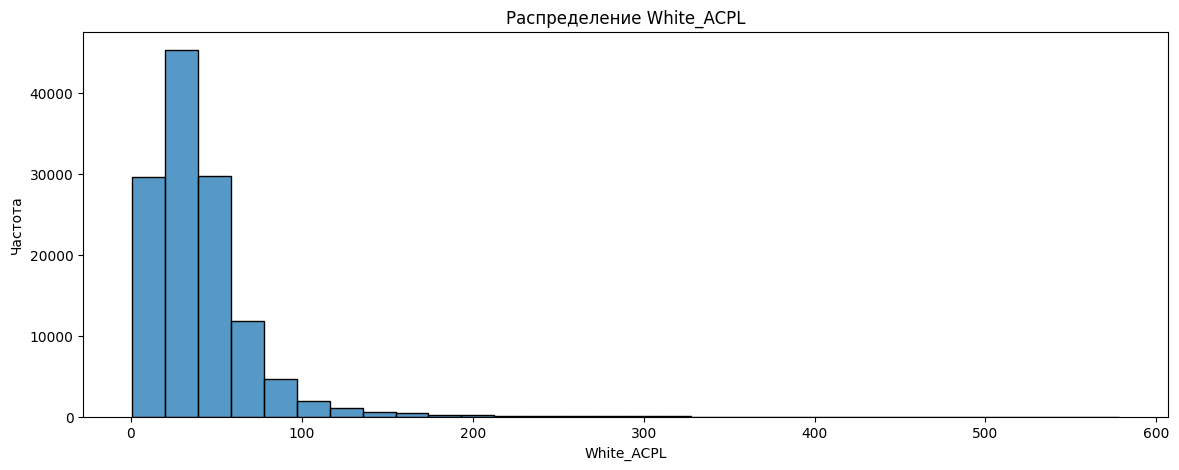

In [52]:
plt.figure(figsize=(14, 5))
sns.histplot(df['White_ACPL'], bins=30)
plt.title('Распределение White_ACPL')
plt.xlabel('White_ACPL')
plt.ylabel('Частота')
plt.show()

Распределение имеет положительную асимметрию (хвост уходит вправо), поэтому применим логарифмирование для уменьшения разброса значений и приведения данных к более нормальному виду.

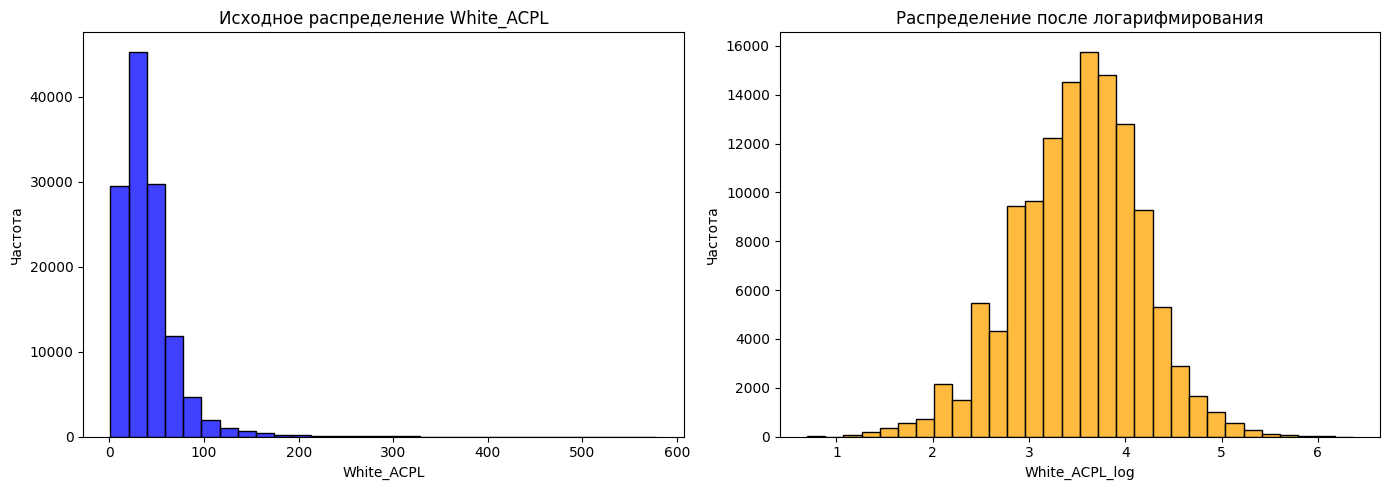

In [53]:
# Логарифмируем
df['White_ACPL_log'] = np.log1p(df['White_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['White_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение White_ACPL")
ax[0].set_xlabel("White_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['White_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("White_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Black_ACPL`

Black_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

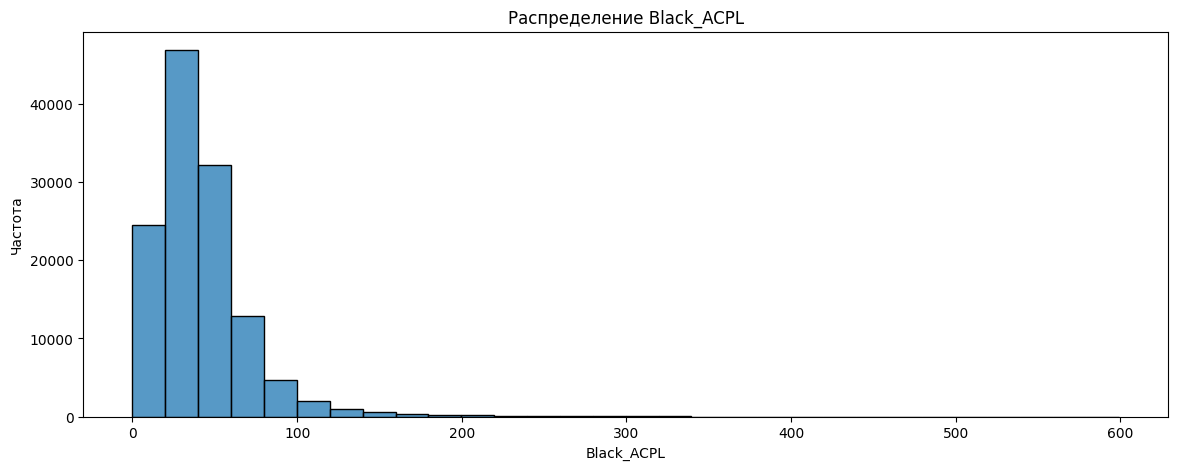

In [54]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Black_ACPL'], bins=30)
plt.title('Распределение Black_ACPL')
plt.xlabel('Black_ACPL')
plt.ylabel('Частота')
plt.show()

Повторим действия, как для White_ACPL

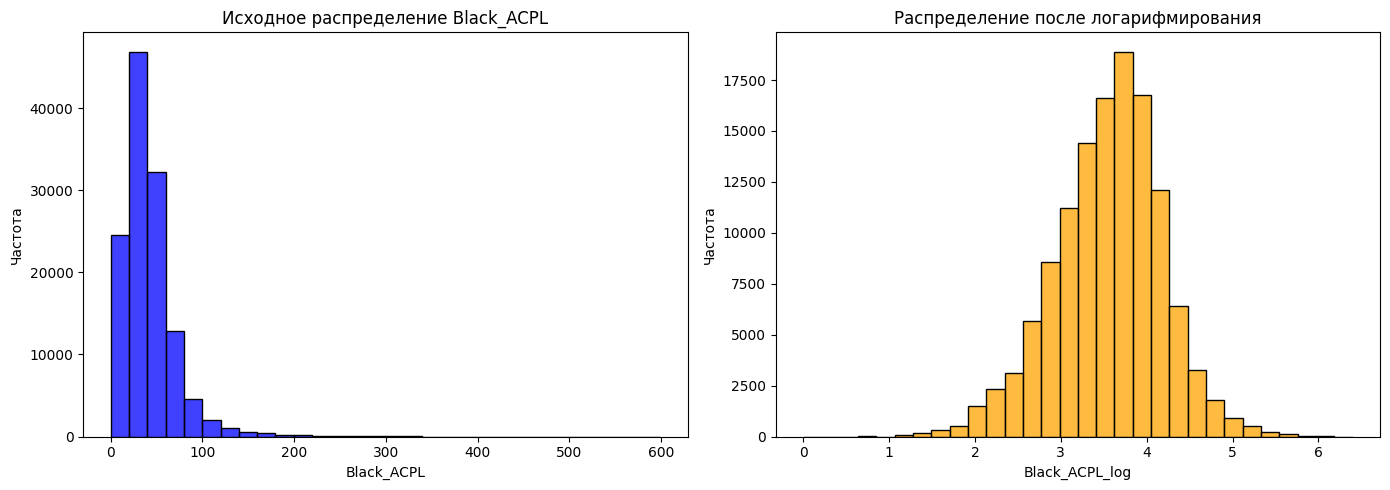

In [55]:
# Логарифмируем
df['Black_ACPL_log'] = np.log1p(df['Black_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Black_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Black_ACPL")
ax[0].set_xlabel("Black_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['Black_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Black_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Clocks`

Clocks - информация о времени игроков по ходу партии в виде последовательного числового списка - категориальный

##### Новый параметр `White_Clocks` и `White_Clocks_Diffs`

Выделим отдельным параметром остаток времени на таймере игрока белыми фигруами после каждого хода

In [56]:
df['White_Clocks'] = df['Clocks'].apply(lambda x: x[::2])

Посчитаем затрачиваемое время на каждый ход игрока белыми фигурами

In [57]:
def calculate_time_spent_with_increment(clock_list, increment):
    clocks_sec = [x / 100 for x in clock_list]
    spent = []
    for i in range(1, len(clocks_sec)):
        time_used = clocks_sec[i - 1] - clocks_sec[i] + increment
        spent.append(round(max(time_used, 0), 2))
    return spent


df['White_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['White_Clocks'], row['Total_Time_Increment']), axis=1)

In [58]:
df['White_Clocks_Diffs']

0         [15.04, 1.6, 2.08, 1.92, 0.0, 77.2, 55.68, 56....
1         [1.76, 12.08, 14.32, 70.32, 6.88, 19.52, 8.8, ...
2         [2.96, 6.56, 2.56, 2.64, 2.96, 2.88, 2.72, 3.0...
3         [2.72, 2.88, 1.92, 2.08, 1.6, 6.24, 10.08, 4.0...
4         [1.36, 48.0, 10.72, 1.2, 5.44, 24.88, 110.56, ...
                                ...                        
125630    [0.16, 0.32, 0.32, 0.4, 0.72, 0.24, 0.96, 0.56...
125631    [0.0, 0.96, 1.36, 0.64, 0.08, 0.4, 1.2, 0.83, ...
125632    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
125633    [0.16, 0.16, 0.16, 0.4, 1.04, 0.48, 0.72, 0.16...
125634    [0.0, 0.96, 0.32, 0.48, 0.48, 0.24, 0.0, 0.32,...
Name: White_Clocks_Diffs, Length: 125635, dtype: object

##### Новый параметр `Black_Clocks` и `Black_Clocks_Diffs`

In [59]:
df['Black_Clocks'] = df['Clocks'].apply(lambda x: x[1::2])

In [60]:
df['Black_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['Black_Clocks'], row['Total_Time_Increment']), axis=1)

#### Параметр `Analysis`

Analysis - данные анализа партии от Lichess движка - категориальный

In [61]:
# TODO: что с этим полем?

#### Параметр `Total_Time_Init`

Total_Time_Init - начальное время на партию в секундах - числовой

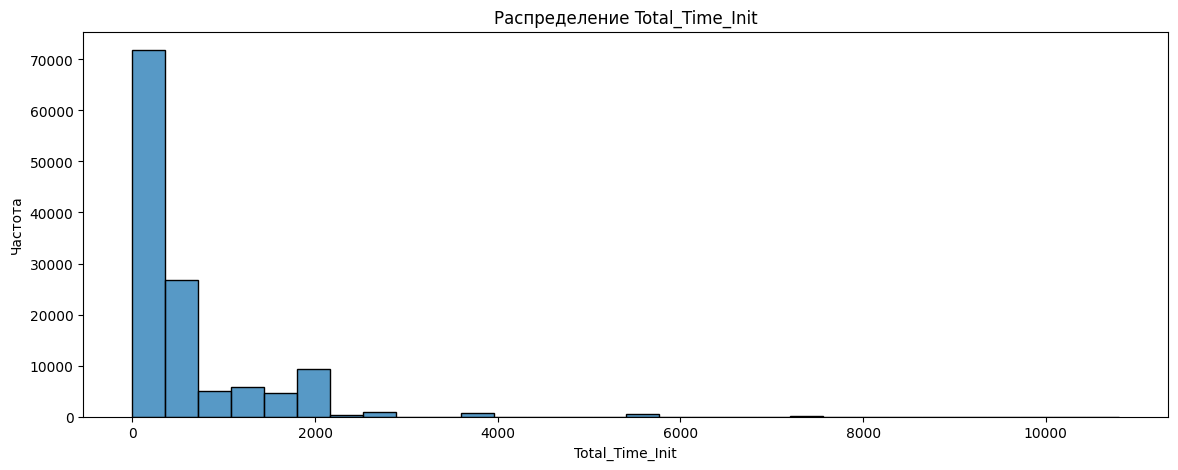

In [62]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Init'], bins=30)
plt.title('Распределение Total_Time_Init')
plt.xlabel('Total_Time_Init')
plt.ylabel('Частота')
plt.show()

Классические турниры по шахматам имеют стартовое время 60 минут и 90 минут в офлайне или менее. В онлайне партий с большим стартовым временем встречается очень мало, поэтому удалим все значения, что больше показателя в 2000 секунд и построим снова распределение

In [63]:
df = df[df['Total_Time_Init'] <= 2000].reset_index(drop=True)

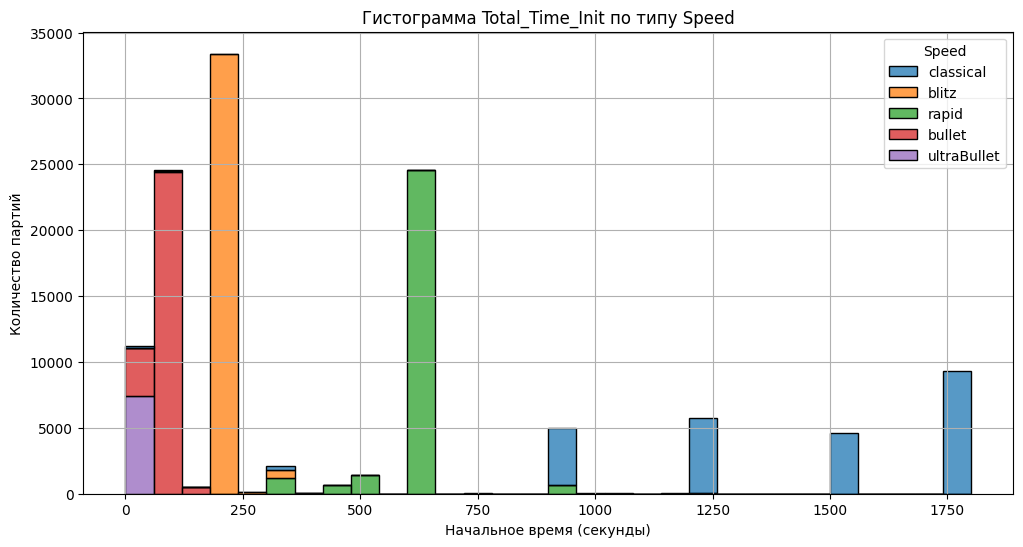

In [64]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Total_Time_Init',
             hue='Speed', multiple='stack', bins=30)
plt.title('Гистограмма Total_Time_Init по типу Speed')
plt.xlabel('Начальное время (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

Мы видим, что распределение практически совпадает с группами параметра `Speed`

#### Параметр `Total_Time_Increment`

Total_Time_Increment - добавление времени за ход в секундах - числовой

Посмотрим на распределение параметра

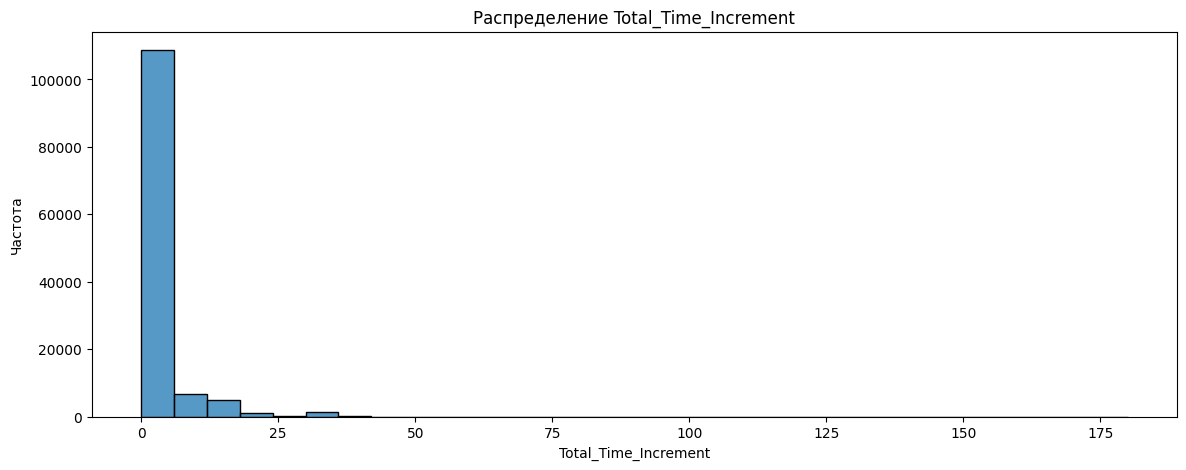

In [65]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Видим что имеется большое кол-во выбросов. 
На практике классическим добавлением на ход по регламенту FIDE яв-ся 30 секунд. Что мы и видим на графике. 
Все, что больше 30 секунд добавления яв-ся нестандартной игрой. Поэтому удалим эти значения и затем построим новый график

In [66]:
df = df[df['Total_Time_Increment'] <= 31].reset_index(drop=True)

Посмотрим снова на распределение

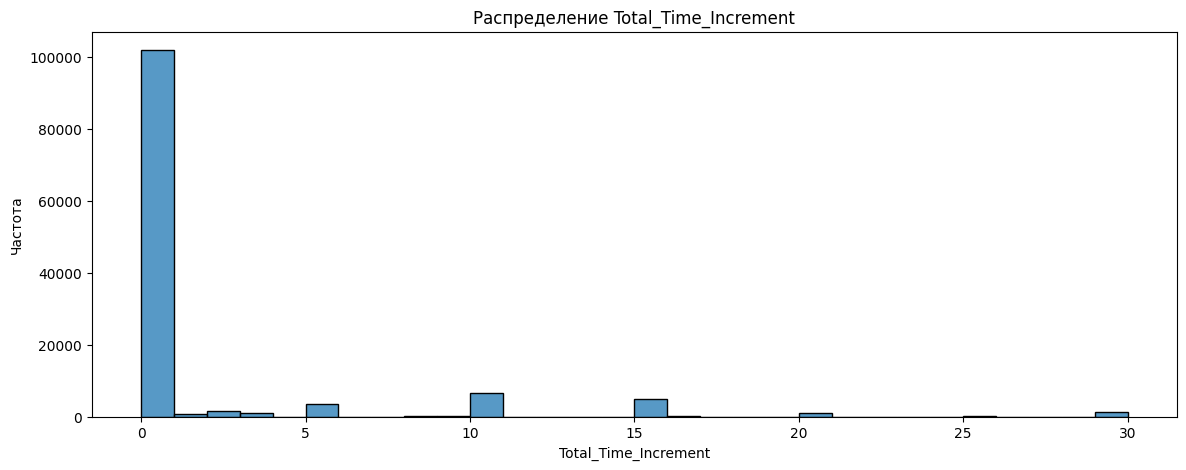

In [67]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Создадим категориальный параметр для объединения распределений по группам

In [68]:
def group_increment(x):
    if x == 0:
        return '0 sec'
    elif x <= 3:
        return '1–3 sec'
    elif x <= 10:
        return '4–8 sec'
    elif x <= 15:
        return '9–15 sec'
    else:
        return '15+ sec'


df['Total_Time_Increment_Group'] = df['Total_Time_Increment'].apply(
    group_increment)

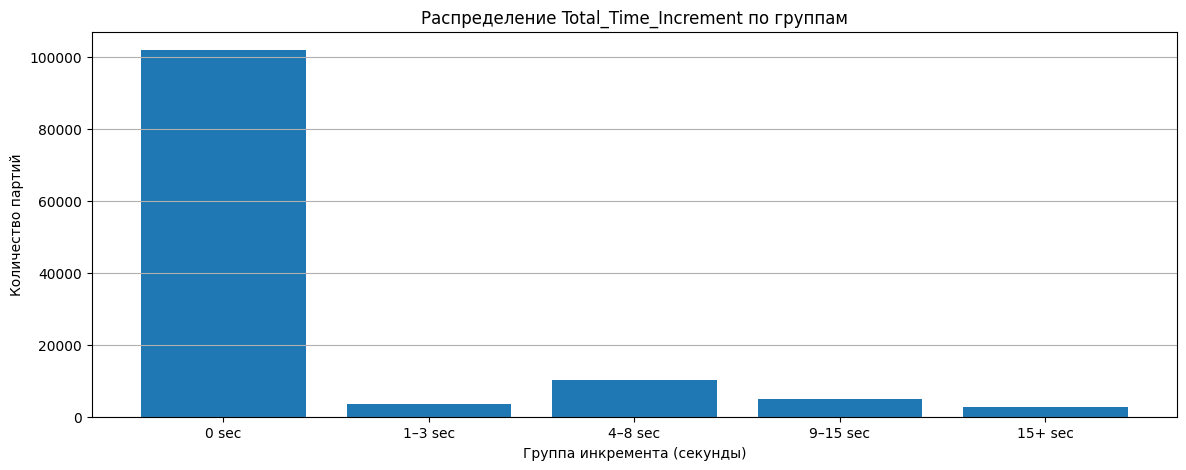

In [69]:
ordered_groups = ['0 sec', '1–3 sec', '4–8 sec', '9–15 sec', '15+ sec']

group_counts = df['Total_Time_Increment_Group'].value_counts().reindex(
    ordered_groups)

plt.figure(figsize=(14, 5))
plt.bar(group_counts.index, group_counts.values)
plt.title("Распределение Total_Time_Increment по группам")
plt.xlabel("Группа инкремента (секунды)")
plt.ylabel("Количество партий")
plt.grid(axis='y')
plt.show()

#### Параметр `Total_Time`

Total_Time - общее затраченное время на партию - числовой

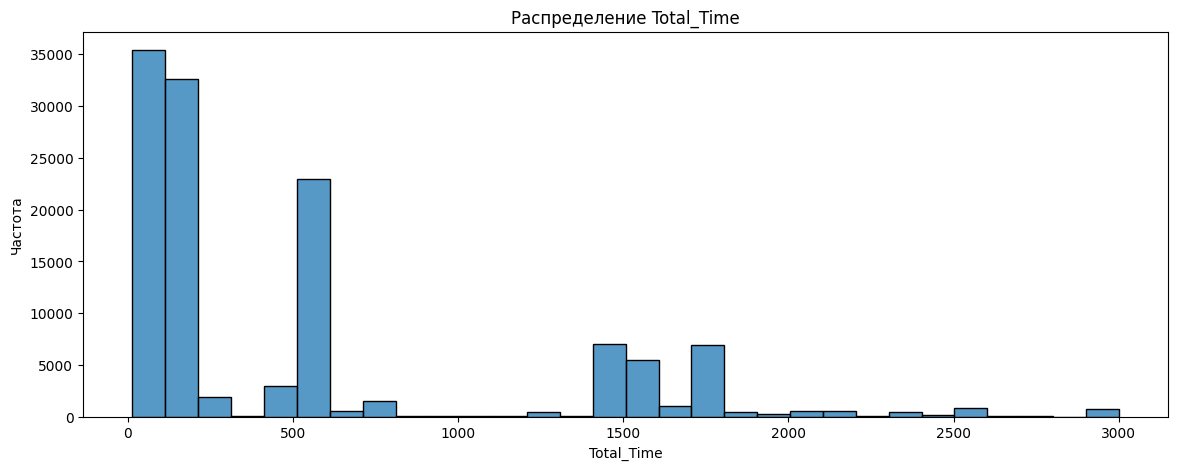

In [70]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time'], bins=30)
plt.title('Распределение Total_Time')
plt.xlabel('Total_Time')
plt.ylabel('Частота')
plt.show()

In [71]:
# TODO: что делать с этим?
# Кажется, что этот столбец нужно дропнуть. Он не совпадает ни с Game_Duration, ни

In [72]:
# df[df['Total_Time_Increment'] > 0][['Num_Moves', 'Total_Time_Increment', 'Total_Time_Init', 'Total_Time', 'Game_Duration']]

#### Параметр `Moves`

Moves - список ходов, сделанных в партии - категориальный

Посмотрим какие самые популярные начальные ходы делаются в партиях.

In [73]:
df["Moves"].apply(lambda x: x.split()[:6]).value_counts()

Moves
[e4, c5, Nf3, d6, d4, cxd4]       4164
[e4, e5, Nf3, Nc6, Bb5, a6]       2182
[e4, c5, Nf3, e6, d4, cxd4]       2074
[d4, Nf6, c4, e6, Nc3, Bb4]       1748
[e4, c5, Nf3, Nc6, d4, cxd4]      1736
                                  ... 
[e4, e6, Nc3, Nf6, d4, Bc5]          1
[e4, d5, Nc3, dxe4, Nxe4, Bg4]       1
[Nf3, a5, e3, a4, Be2, e5]           1
[h4, c5, e3, Nc6, Nc3, Nf6]          1
[e4, e6, Nf3, Ne7, d4, Ng6]          1
Name: count, Length: 20120, dtype: int64

Посмотрим какой фигурой чаще всего делается последний ход

In [74]:
df["Moves"].apply(lambda x: "P" if x.split()[-1][0].islower() else x.split()
                           [-1][0] if x.split()[-1][0] != "O" else "Castle").value_counts()

Moves
Q         33227
R         29219
K         18876
P         16500
B         12767
N         12395
Castle      109
Name: count, dtype: int64

Чаще всего завершает игру ход Ферзем или ладьей

#### Новый параметр `is_Berserk`

Создадим параметр, показывающий брал ли игрок берсерк режим на партию

In [75]:
# TODO: реализовать

#### Новый параметр `Game_Duration`

Создадим на основе параметров `Created_At` и `Last_Move_At` параметр - продолжительность партии

In [76]:
df['Game_Duration'] = (df['Last_Move_At'] - df['Created_At']).dt.total_seconds()

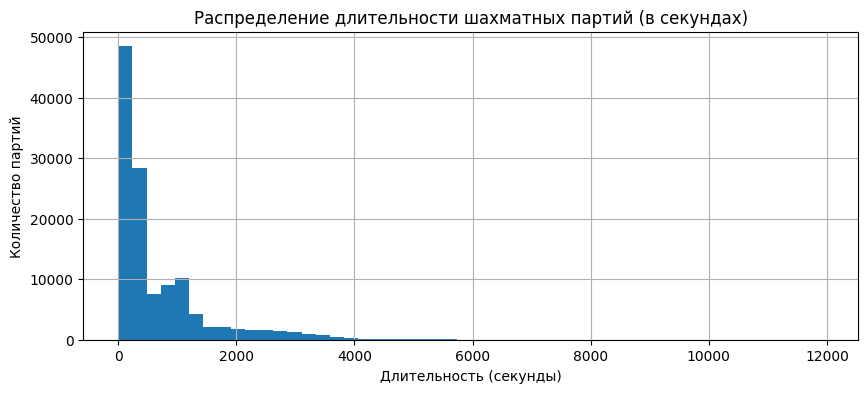

In [77]:
plt.figure(figsize=(10, 4))
plt.hist(df['Game_Duration'], bins=50)
plt.title('Распределение длительности шахматных партий (в секундах)')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

In [78]:
# TODO: Удаляем выбросы?
# TODO: Сравнить с Total_Time

#### Новый параметр `Num_Moves`

На основе параметра Moves - список ходов, сделанных в партии - категориальный.
Создадим новый параметр кол-во ходов в партии

In [79]:
df["Num_Moves"] = df["Moves"].apply(
    lambda x: len(x.split()) // 2)

Посмотрим на распределение параметра и описательную статистику

In [80]:
df["Num_Moves"].describe()

count    123093.000000
mean         41.939932
std          18.286246
min           2.000000
25%          28.000000
50%          39.000000
75%          53.000000
max         229.000000
Name: Num_Moves, dtype: float64

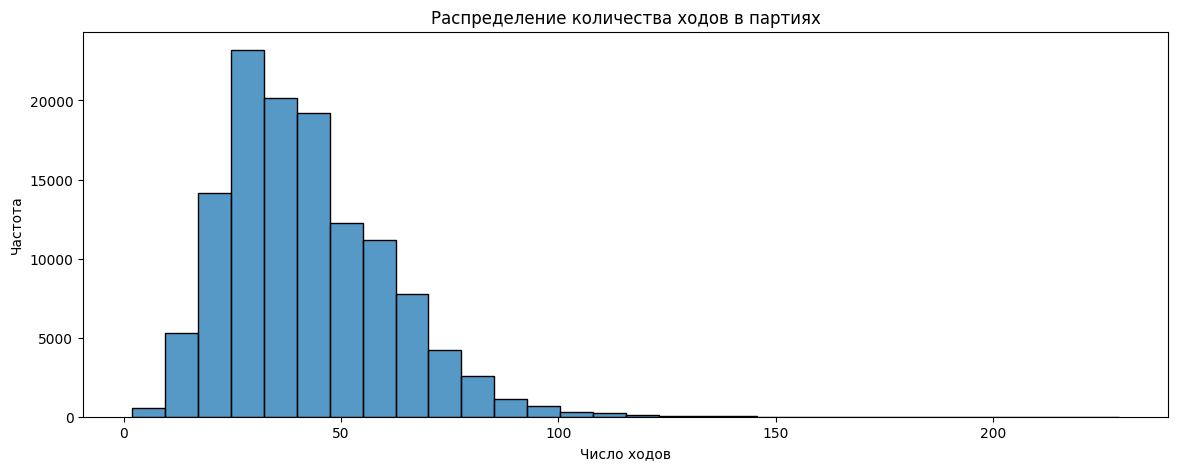

In [81]:
plt.figure(figsize=(14, 5))
sns.histplot(df["Num_Moves"], bins=30)
plt.title("Распределение количества ходов в партиях")
plt.xlabel("Число ходов")
plt.ylabel("Частота")
plt.show()

## Корреляционная матрица

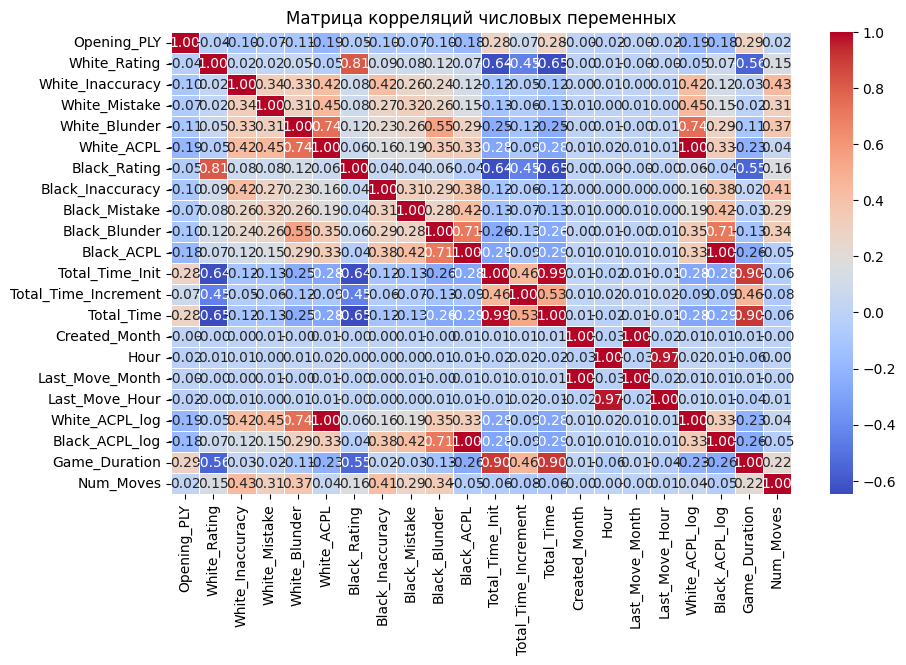

In [82]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций числовых переменных")
plt.show()

In [83]:
# TODO: Добавить категориальные признаки

In [84]:
# TODO: Выводы по матрице